<a href="https://colab.research.google.com/github/amit-420/legged_course/blob/main/legged_module_3_dynamic_passive_walker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import sympy as sp
import matplotlib.pylab as plt
from scipy.integrate import solve_ivp
import matplotlib.animation as animation 
import matplotlib.pyplot as plt 
from scipy.integrate import odeint,ode
from scipy.optimize import fsolve

In [7]:
import casadi as ca

In [8]:
t1, t2, gamma, x, y, xdot,ydot, l, c, I, w1, w2, m, M = sp.symbols('theta1,theta2, gamma, x, y, xdot, ydot, l,c,I, omega1, omega2, m, M')

g = sp.symbols('g')

q = sp.Matrix([x,y,t1,t2])
qdot = sp.Matrix([xdot,ydot,w1,w2])


def i_1Ti(t,x,y):
    return sp.Matrix([[sp.cos(t), -sp.sin(t), x],
                     [sp.sin(t), sp.cos(t),   y],
                     [0,        0,            1]])


'''Finding Homogenious Transformation matrices'''
Tg = i_1Ti(-gamma,0,0)
T1 = i_1Ti((sp.pi/2) + t1,x,y)
T2 = i_1Ti(t2 - sp.pi,l,0)



''' position of leg 1 COM in ramp frame '''
X0g1 = T1@sp.Matrix([l-c,0,1])     

'''Position of hip in ramp frame '''
X0h1 = T1@sp.Matrix([l,0,1])        

''' position of leg2 COM in ramp frame '''
X0g2 = T1@T2@sp.Matrix([c,0,1])     

''' Position of end point of leg 2 in ramp frame '''
X0c2 = T1@T2@sp.Matrix([l,0,1])     



''' position in ground frame '''
Xgg1 = Tg @ X0g1

Xgh1 = Tg @ X0h1

Xgg2 = Tg @ X0g2

Xgc2 = Tg @ X0c2



X0g1 = sp.Matrix(X0g1[0:2])

X0h1 = sp.Matrix(X0h1[0:2])

X0g2 = sp.Matrix(X0g2[0:2])

X0c2 = sp.Matrix(X0c2[0:2])

X0g1

Matrix([
[x - (-c + l)*sin(theta1)],
[y + (-c + l)*cos(theta1)]])

In [9]:
X0g2

Matrix([
[c*(sin(theta1)*cos(theta2) + sin(theta2)*cos(theta1)) - l*sin(theta1) + x],
[c*(sin(theta1)*sin(theta2) - cos(theta1)*cos(theta2)) + l*cos(theta1) + y]])

In [10]:
sp.simplify(X0c2)

Matrix([
[-l*sin(theta1) + l*sin(theta1 + theta2) + x],
[ l*cos(theta1) - l*cos(theta1 + theta2) + y]])

In [11]:
X0h1

Matrix([
[-l*sin(theta1) + x],
[ l*cos(theta1) + y]])

In [12]:
Vh = X0h1.jacobian(q)@sp.Matrix(qdot)
Vg1 = X0g1.jacobian(q)@sp.Matrix(qdot)
Vg2 = X0g2.jacobian(q)@sp.Matrix(qdot)
Vh

Matrix([
[-l*omega1*cos(theta1) + xdot],
[-l*omega1*sin(theta1) + ydot]])

In [13]:
Vg1

Matrix([
[  omega1*(c - l)*cos(theta1) + xdot],
[-omega1*(-c + l)*sin(theta1) + ydot]])

In [14]:
Vg2

Matrix([
[c*omega2*(-sin(theta1)*sin(theta2) + cos(theta1)*cos(theta2)) + omega1*(c*(-sin(theta1)*sin(theta2) + cos(theta1)*cos(theta2)) - l*cos(theta1)) + xdot],
[  c*omega2*(sin(theta1)*cos(theta2) + sin(theta2)*cos(theta1)) + omega1*(c*(sin(theta1)*cos(theta2) + sin(theta2)*cos(theta1)) - l*sin(theta1)) + ydot]])

In [15]:
T = sp.simplify((0.5 *m * ( Vg1.T @ Vg1))[0] + (0.5 *m * ( Vg2.T @ Vg2) )[0] + (0.5 * M * ( Vh.T @ Vh) )[0] + 0.5*I*w1**2 + 0.5*I*(w1+w2)**2)
T

0.5*I*omega1**2 + 0.5*I*(omega1 + omega2)**2 + 0.5*M*((l*omega1*sin(theta1) - ydot)**2 + (l*omega1*cos(theta1) - xdot)**2) + 0.5*m*((omega1*(c - l)*sin(theta1) + ydot)**2 + (omega1*(c - l)*cos(theta1) + xdot)**2) + 0.5*m*((c*omega2*sin(theta1 + theta2) + omega1*(c*sin(theta1 + theta2) - l*sin(theta1)) + ydot)**2 + (-c*omega2*cos(theta1 + theta2) + omega1*(-c*cos(theta1 + theta2) + l*cos(theta1)) - xdot)**2)

In [16]:
V = sp.simplify(m*g*Xgg1[1] + m*g*Xgg2[1] + M*g*Xgh1[1])
V

g*(M*l*cos(gamma - theta1) - M*x*sin(gamma) + M*y*cos(gamma) - c*m*cos(gamma - theta1) - c*m*cos(-gamma + theta1 + theta2) + 2*l*m*cos(gamma - theta1) - 2*m*x*sin(gamma) + 2*m*y*cos(gamma))

In [17]:
L = sp.simplify(T - V)
L

0.5*I*omega1**2 + 0.5*I*(omega1 + omega2)**2 + 0.5*M*((l*omega1*sin(theta1) - ydot)**2 + (l*omega1*cos(theta1) - xdot)**2) - g*(M*l*cos(gamma - theta1) - M*x*sin(gamma) + M*y*cos(gamma) - c*m*cos(gamma - theta1) - c*m*cos(-gamma + theta1 + theta2) + 2*l*m*cos(gamma - theta1) - 2*m*x*sin(gamma) + 2*m*y*cos(gamma)) + 0.5*m*((omega1*(c - l)*sin(theta1) + ydot)**2 + (omega1*(c - l)*cos(theta1) + xdot)**2) + 0.5*m*((c*omega2*sin(theta1 + theta2) + omega1*(c*sin(theta1 + theta2) - l*sin(theta1)) + ydot)**2 + (c*omega2*cos(theta1 + theta2) + omega1*(c*cos(theta1 + theta2) - l*cos(theta1)) + xdot)**2)

In [18]:
dLdq = sp.diff(L,q)
dLdq.shape

(4, 1)

In [19]:
dLdqdot = sp.diff(L,qdot)
dLdqdot.shape

(4, 1)

In [20]:
xddot,yddot,w1dot, w2dot = sp.symbols('xddot,yddot,omegadot1, omegadot2')
qddot = sp.Matrix([xddot, yddot, w1dot,w2dot])
#qddot = qddot.subs({xddot:0,yddot:0})
qddot

Matrix([
[    xddot],
[    yddot],
[omegadot1],
[omegadot2]])

In [21]:
ddt_dLdqdot = sp.Matrix([sp.diff(dLdqdot[0],qdot).T,sp.diff(dLdqdot[1],qdot).T,
                         sp.diff(dLdqdot[2],qdot).T,
                         sp.diff(dLdqdot[3],qdot).T])@qddot + sp.Matrix([sp.diff(dLdqdot[0],q).T,
                         sp.diff(dLdqdot[1],q).T,
                         sp.diff(dLdqdot[2],q).T,
                         sp.diff(dLdqdot[3],q).T])@qdot
ddt_dLdqdot.shape

(4, 1)

In [22]:
eom = ddt_dLdqdot - dLdq
eom.shape

(4, 1)

In [23]:
B = sp.simplify(eom.subs({w1dot:0,w2dot:0, xddot: 0,yddot: 0}))
B

Matrix([
[-1.0*c*m*omega2*(omega1 + omega2)*sin(theta1 + theta2) - g*(M + 2*m)*sin(gamma) - omega1*(-1.0*M*l*omega1*sin(theta1) + 1.0*m*omega1*(c - l)*sin(theta1) + m*(c*omega2*sin(theta1 + theta2) + omega1*(c*sin(theta1 + theta2) - l*sin(theta1))))],
[     c*m*omega2*(omega1 + omega2)*cos(theta1 + theta2) + g*(M + 2*m)*cos(gamma) + omega1*(-1.0*M*l*omega1*cos(theta1) + 1.0*m*omega1*(c - l)*cos(theta1) + m*(c*omega2*cos(theta1 + theta2) + omega1*(c*cos(theta1 + theta2) - l*cos(theta1))))],
[                                                    M*g*l*sin(gamma - theta1) - c*g*m*sin(gamma - theta1) + c*g*m*sin(-gamma + theta1 + theta2) + 2*c*l*m*omega1*omega2*sin(theta2) + c*l*m*omega2**2*sin(theta2) + 2*g*l*m*sin(gamma - theta1)],
[                                                                                                                                                                                c*m*(g*sin(-gamma + theta1 + theta2) - l*omega1**2*sin(theta2))]])

In [24]:
Mass_m = sp.simplify(eom.jacobian(qddot))
Mass_m.shape

(4, 4)

In [25]:
G = B.subs({w1:0,w2:0})
G.shape

(4, 1)

In [26]:
C = B - G
C.shape

(4, 1)

In [27]:
class passive_dynamic_walker():
    def __init__(self,m= 0.5,M = 1, I = 0.1, c = 0.5, l = 1, g = 1, gamma = 0.01):
        self.m = m
        self.M = M
        self.I = I
        self.c = c
        self.l = l
        self.g = g
        self.gamma = gamma
        self.z = np.array([0.16,-0.32,-0.239,0.38])
#         self.z = np.array([0.162597833780041, -0.325195667560083, -0.231869638058930, 0.037978468073743])#np.array([ 0.162597833780041, -0.231869638058930,  -0.325195667560083   0.037978468073743]) ## [theta1,theta2,omega1,omega2]
        self.T = np.array([[0, 0]]).T
        self.Z = np.array([np.concatenate((self.z,np.array([0,0])))])
        self.t_end = 4

    def set_equations(self,Mass_m,C,G,B):
        
        Mass_m = Mass_m.subs({l:self.l, c:self.c, I:self.I, m:0.5, M:self.M})
        B = B.subs({l:self.l, c:self.c, I:self.I, m:0.5, M:self.M, gamma: self.gamma,g:self.g})
        
        self.Mass_m = sp.lambdify([t1, t2],Mass_m)
        self.B = sp.lambdify([t1, t2, w1, w2],B)
    
    def get_T(self,z):
        return np.array([[0,0]]).T 

    def single_stance(self,t,z):
        '''
        Finding zdot numerically

        wdot =  M_inv * (T - C - G)
        '''
        M34 = np.array([[self.Mass_m(z[0],z[1])[2][2],self.Mass_m(z[0],z[1])[2][3]],
                        [self.Mass_m(z[0],z[1])[3][2],self.Mass_m(z[0],z[1])[3][3]]])
#         print(M34)
        wdot = np.linalg.inv(M34)@np.array(self.get_T(z) - self.B(z[0],z[1],z[2],z[3])[2:4])
        
        return np.array([z[2],z[3],wdot[0][0],wdot[1][0]],dtype=object)

        
    def one_step(self,z):
        self.z = z
        eqn = ode(self.single_stance)
        eqn.set_initial_value(self.z,0)
        dt = 0.01
        x_start = self.Z[-1][4] + self.l*np.sin(self.z[0])
        #y_start = self.l*np.sin(theta1)
        while eqn.successful() and self.collision() and (self.t_end - eqn.t) > 0:
            self.z = eqn.integrate(eqn.t+dt)
            z_temp = np.concatenate(([self.z],[[x_start - self.l*np.sin(self.z[0]), self.l*np.cos(self.z[0])]]),axis=None)
            self.Z = np.append(self.Z,[z_temp],axis=0)
        
        self.z = self.foot_strike()
        return self.z
        
        
    def foot_strike(self):
        z = self.Z[-1]
        Jc2 = X0c2.jacobian(q)
        Jc2 = Jc2.subs({l:self.l})
        Jc2 = sp.lambdify([t1, t2],Jc2)
        Jc2 = Jc2(z[0],z[1])
        X_n_hs = np.array([0,0,z[2],z[3]])
        A_mm = np.concatenate((np.concatenate((self.Mass_m(z[0],z[1]),-1*Jc2.T),axis=1),np.concatenate((Jc2,np.zeros((2,2))),axis=1)),axis=0)
        
        b_hs = np.concatenate(([self.Mass_m(z[0],z[1])@X_n_hs],np.zeros((1,2))), axis=None)
        
        Next_X = np.linalg.inv(A_mm)@b_hs
        
        return np.array([z[0] + z[1] ,-z[1],Next_X[2]+ Next_X[3],-Next_X[3]])
        
    def collision(self):
        
        if abs(self.z[1] + 2*self.z[0]) < 0.01:
            
            if self.z[0]  > -0.05:
                return True
            else:
                return False
        else:
            return True
        
        
    def start_walker(self,steps,z):
        i = 0
        self.z = z
        while (steps > i):
            self.z = self.one_step(self.z)
            i += 1
        return self.z
        
        
p1 = passive_dynamic_walker()

p1.set_equations(Mass_m,C,G,B)

p1.start_walker(2,p1.z)

print(len(p1.Z))



514


In [28]:
class save_animation(passive_dynamic_walker):
    def __init__(self,x,y,xh,yh):
        super().__init__()
        self.X = x
        self.Y = y
        self.Xh = xh
        self.Yh = yh
        self.fig = plt.figure() 
        self.axis = plt.axes(autoscale_on=False,xlim = (-0.5, 2),
                            ylim = (-0.1, 2)) 
        self.time_template = 'time = %.1fs \nSlope: 0.01 radian'
        self.time_text = self.axis.text(0.05, 0.9, '', transform=self.axis.transAxes)
        self.axis.set_aspect('equal')
        self.axis.grid()
        self.point1, = self.axis.plot(0,0, marker='o') 
        self.line1, = self.axis.plot([],[], lw = 2)
        self.ramp, = self.axis.plot([],[], "black", lw = 2)
        
    def interpolate(self):
        #self.X_n,self.Y_n, self.Xh_n, self.Yh_n = np.zeros((np.int(len(self.X)/2)+1)), np.zeros((np.int(len(self.X)/2)+1)), np.zeros((np.int(len(self.X)/2)+1)), np.zeros((np.int(len(self.X)/2)+1))
        self.X_n,self.Y_n, self.Xh_n, self.Yh_n = np.zeros((np.int(len(self.X)+1))), np.zeros((np.int(len(self.X))+1)), np.zeros((np.int(len(self.X))+1)), np.zeros((np.int(len(self.X))+1))
        for i in range(0,len(self.X)):
            index = int(i)
            self.X_n[index] = self.X[i] 
            self.Y_n[index] = self.Y[i]
            self.Xh_n[index] = self.Xh[i]
            self.Yh_n[index] = self.Yh[i]
    
    def init(self): 
        self.point1.set_data([],[]) 
        self.line1.set_data([],[])
        self.ramp.set_data([],[])
        return self.point1, self.line1, self.ramp,

    def end_eff(self,i):
        P = np.array([self.Xh_n[i]+self.l*np.sin(self.X_n[i]), self.Yh_n[i]-self.l*np.cos(self.X_n[i])])
        Q = np.array([self.Xh_n[i] + self.l*np.sin(self.X_n[i]+self.Y_n[i]), self.Yh_n[i] - self.l*np.cos(self.X_n[i]+self.Y[i])])
        return P,Q

    def init_q_his(self):
        P,Q = self.end_eff(0)
        self.q_history = np.array([Q])

    def animate(self,i):

        self.point1.set_data(self.Xh_n[i],self.Yh_n[i]) 

        P,Q = self.end_eff(i)
        
        self.line1.set_data([P[0], self.Xh_n[i], Q[0]],[P[1], self.Yh_n[i], Q[1]])
        
        self.ramp.set_data([-0.5,2],[0,0])
        
        self.time_text.set_text(self.time_template % (i*0.01))
        
        return self.point1, self.line1, self.ramp,

    def save(self,file_name = 'results/passive_dynamic_walker.mp4'):
        anim = animation.FuncAnimation(self.fig, self.animate, init_func = self.init, 
                               frames = len(self.X_n)-1, interval = 10, blit = True) 
        anim.save(file_name, writer = 'ffmpeg', fps = 200)
print("save_animation class")

save_animation class


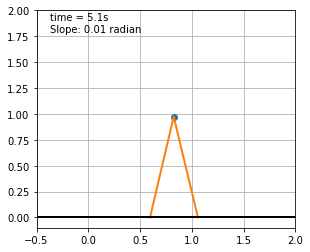

In [29]:
s1 = save_animation(p1.Z[:,0],p1.Z[:,1],p1.Z[:,4],p1.Z[:,5])
s1.interpolate()
s1.init_q_his()
s1.save()

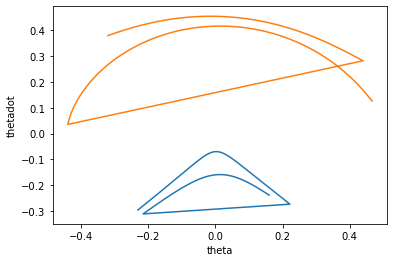

In [30]:

plt.plot(p1.Z[:,0],p1.Z[:,2])
plt.xlabel('theta')
plt.ylabel('thetadot')

plt.plot(p1.Z[:,1],p1.Z[:,3])
plt.show()

In [31]:
import copy
# test_z = np.array([0.162597833780041,  -0.231869638058930 , -0.325195667560083 ,  0.037978468073743])
test_z = np.array([0.16,-0.32,-0.239,0.38])
def jacobian_num(z):
    '''Using Central difference '''
    n = len(z)
    dz = 1e-5
    J = np.zeros((n,n))
    ztemp1 = copy.deepcopy(z)
    ztemp2 = copy.deepcopy(z)
    for i in range(n):
        ztemp1[i] = ztemp1[i] + dz
        ztemp2[i] = ztemp2[i] - dz
        J[i] = p1.one_step(ztemp1) - p1.one_step(ztemp2)
    return J/2*dz


J = jacobian_num(test_z)
egen, egen_vec = np.linalg.eig(J)

egen_norm = np.absolute(egen)

print(egen)
egen_norm

[7.10376220e-10 7.20966229e-11 5.26214814e-13 6.77708142e-12]


array([7.10376220e-10, 7.20966229e-11, 5.26214814e-13, 6.77708142e-12])

In [32]:
class root_finding(passive_dynamic_walker):
    def __init__(self,m):
        super().__init__(self,m)
        
    def fixed_pt(self,z):
        
        self.zdiff = z - self.start_walker(1,z)
        return self.zdiff
    
    def calculate(self):
        self.z = np.array([0.14485748 ,-0.28076993 ,-0.1898726 ,  0.963972])
        print(f"Initial guess: {self.z}")
        self.root = fsolve(self.fixed_pt,self.z,full_output = True)
        
        print(f"Exit flag: {self.root[2]}")
        print(f"Remark: {self.root[3]}")
        print(f"Probable root: {self.root[0]}")
        print(f"Function output at the root: {self.root[1]['fvec']}")
        
        
#         
        
o1 = root_finding(0.5)
o1.set_equations(Mass_m,C,G,B)
o1.calculate()

Initial guess: [ 0.14485748 -0.28076993 -0.1898726   0.963972  ]
Exit flag: 5
Remark: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Probable root: [ 0.14226472  0.01385808 -0.10921898  0.36128836]
Function output at the root: [0.088128   0.11910444 0.01926627 0.35962789]
